In [1]:
from pathlib import Path
from cellpose import io


data_root = Path().home() / 'projects/cellpose/test_train/'
image_files = list((data_root / 'test').iterdir())
image_files = [i for i in image_files if 'masks' not in i.name and 'flow' not in i.name and i.is_file()]
image_files.sort()

print(f" number of images : {len(image_files)}")

img = io.imread_2D(image_files[0])



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.1 
platform:       	linux 
python version: 	3.12.3 
torch version:  	2.8.0.dev20250505+cu128! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


 number of images : 68


# Show model weight size, and dtype:

In [2]:
def get_memory_footprint(model, return_buffers=True):
    mem = sum([param.nelement() * param.element_size() for param in model.parameters()])
    if return_buffers:
        mem_bufs = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
    mem += mem_bufs
    return mem / 1024**2  # convert to MB

def get_type_counts(model):
    type_counts = {}
    for param in model.parameters():
        param_type = str(param.dtype)
        if param_type not in type_counts:
            type_counts[param_type] = 0
        type_counts[param_type] += param.nelement() * param.element_size()
    return type_counts

In [3]:
from cellpose import models

model = models.CellposeModel(gpu=True)

print(get_type_counts(model.net))
print(f'Model size: {get_memory_footprint(model.net):.2f} MB')

{'torch.float32': 1218515720}
Model size: 1162.07 MB


## Calculate the AP scores for masks with normal model weights:  

In [4]:
import time
from tqdm import tqdm

masks = []
times = []
for img_f in image_files:
    img = io.imread_2D(img_f)
    tic = time.time()
    masks_i, flows_i, _ = model.eval(img)
    toc = time.time()

    img_f_out = data_root / 'quantization/fp32' / img_f.name
    img_f_out.parent.mkdir(parents=True, exist_ok=True)
    io.imsave(img_f_out, masks_i)
    times.append(toc-tic)
    masks.append(masks_i.max())


0.294391393661499
0.10566282272338867
0.10566210746765137
0.1054537296295166
0.1054391860961914
0.1054220199584961
0.10538077354431152
0.10544037818908691
0.1053924560546875
0.10545110702514648
0.10546135902404785
0.10551738739013672
0.14010334014892578
0.03056049346923828
0.13769793510437012
0.01892995834350586
0.13856029510498047
0.01896953582763672
0.0724632740020752
0.07106661796569824
0.07092642784118652
0.10555696487426758
0.10549330711364746
0.13778305053710938
0.018965721130371094
0.10743331909179688
0.10565423965454102
0.10552358627319336
0.13784480094909668
0.02016282081604004
0.13783907890319824
0.020309925079345703
0.07099795341491699
0.10557174682617188
0.10559439659118652
0.07105278968811035
0.10557770729064941
0.07100772857666016
0.07098531723022461
0.07098126411437988
0.10552239418029785
0.10556793212890625
0.13777732849121094
0.01897907257080078
0.07097315788269043
0.10598492622375488
0.07102131843566895
0.10643315315246582
0.10553717613220215
0.13783693313598633
0.070

# Evaluate the model with lower precision data type: 

In [5]:
import torch 
import numpy as np

model.net.dtype = torch.bfloat16
model.net.to(model.net.dtype)


Transformer(
  (encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(8, 8), stride=(8, 8))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()

In [6]:
print(get_type_counts(model.net))
print(f'Model size: {get_memory_footprint(model.net):.2f} MB')


{'torch.bfloat16': 609257860}
Model size: 581.03 MB


In [7]:
import numpy as np
from cellpose import core


masks = []
times_16 = []
times_16_net = []
for img_f in image_files:
    img = io.imread_2D(img_f)
    tic = time.time()
    masks_i, flows_i, _ = model.eval(img)
    toc = time.time()

    img_f_out = data_root / 'quantization/bfp16' / img_f.name
    img_f_out.parent.mkdir(parents=True, exist_ok=True)
    io.imsave(img_f_out, masks_i)
    times_16.append(toc-tic)
    masks.append(masks_i.max())

0.11516189575195312
0.058031558990478516
0.05804800987243652
0.05808424949645996
0.05808281898498535
0.058046817779541016
0.05802583694458008
0.05847907066345215
0.05806088447570801
0.0584867000579834
0.05828237533569336
0.05893754959106445
0.07747244834899902
0.045305490493774414
0.07477998733520508
0.013552665710449219
0.07479357719421387
0.013551950454711914
0.043792009353637695
0.04104137420654297
0.041014909744262695
0.058069705963134766
0.0580294132232666
0.07482671737670898
0.013544797897338867
0.05800151824951172
0.05847024917602539
0.05807852745056152
0.07517027854919434
0.013546228408813477
0.07479357719421387
0.01348733901977539
0.041010379791259766
0.05801200866699219
0.058434486389160156
0.04100942611694336
0.058017730712890625
0.0410466194152832
0.04103398323059082
0.04092764854431152
0.05802440643310547
0.05807328224182129
0.07480764389038086
0.013559579849243164
0.04101085662841797
0.05935239791870117
0.04103398323059082
0.05810737609863281
0.05816531181335449
0.0748276

In [8]:
from cellpose.metrics import average_precision

ap_all = []
for i in range(68):
    true_mask = io.imread(data_root / f'test/{i:03}_masks.png')
    mask_bf16 = io.imread(data_root / f'quantization/bfp16/{i:03}_img.png')
    mask_fp32 = io.imread(data_root / f'quantization/fp32/{i:03}_img.png')

    ap = average_precision([true_mask, true_mask],
                             [mask_bf16, mask_fp32], 
                             threshold=[0.5])[0]
    ap_all.append(ap)

In [9]:
ap_arr = np.hstack(ap_all)
np.mean(ap_arr, axis=1)

array([0.85471886, 0.85487753], dtype=float32)

In [10]:
import seaborn as sns
import pandas as pd


df = pd.DataFrame({
    'dtype': ['bfloat16', 'float32'],
    'AP@0.5': [ap_arr[l, :] for l in range(2)],
})
df = df.explode('AP@0.5')
df['time'] = np.hstack([times_16, times])
df.head()

,dtype,AP@0.5,time
0,bfloat16,0.920455,0.181792
0,bfloat16,0.845238,0.121006
0,bfloat16,0.909091,0.118715
0,bfloat16,0.978723,0.115539
0,bfloat16,0.866667,0.113421


<Axes: xlabel='dtype', ylabel='time'>

/home/michael/projects/cellpose/.venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/michael/projects/cellpose/.venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


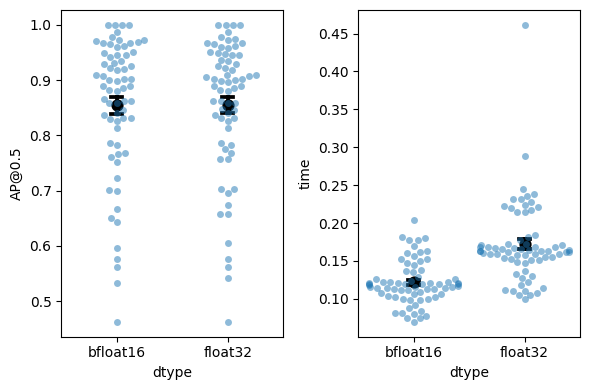

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(6, 4), tight_layout=True)

sns.swarmplot(y='AP@0.5', x='dtype', data=df, alpha=0.5, ax=ax[0], )
sns.pointplot(x='dtype', y='AP@0.5', data=df, errorbar='se', linestyle="none", color='black', capsize=.1, ax=ax[0])

sns.swarmplot(y='time', x='dtype', data=df, alpha=0.5, ax=ax[1], )
sns.pointplot(x='dtype', y='time', data=df, errorbar='se', linestyle="none", color='black', capsize=.1, ax=ax[1])

In [12]:
df.groupby('dtype').mean()

,AP@0.5,time
dtype,,
bfloat16,0.854719,0.121736
float32,0.854877,0.171985


In [13]:
(0.172814 - 0.123416) / 0.172814 

0.2858448968254887

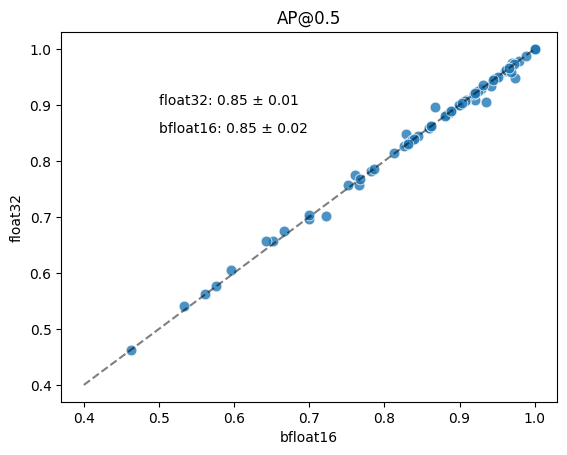

In [14]:
sns.scatterplot(x=df[df['dtype'] == 'bfloat16']['AP@0.5'].values,
                y=df[df['dtype'] == 'float32']['AP@0.5'].values, 
                alpha=0.8, s=60)
plt.plot([0.4, 1], [0.4, 1], 'k--', alpha=0.5)

plt.xlabel('bfloat16')
plt.ylabel('float32')
plt.title('AP@0.5')

mean_16 = df[df["dtype"] == "bfloat16"]["AP@0.5"].mean()
sem_16 = df[df["dtype"] == "bfloat16"]["AP@0.5"].sem()
mean_fp32 = df[df["dtype"] == "float32"]["AP@0.5"].mean()
sem_fp32 = df[df["dtype"] == "float32"]["AP@0.5"].sem()

b16_text = f"bfloat16: {mean_16:.2f} ± {sem_16:.2f}"
fp32_text = f"float32: {mean_fp32:.2f} ± {sem_fp32:.2f}"

#put text in the top left corner inside plot
plt.text(0.5, 0.9, fp32_text, )
plt.text(0.5, 0.85, b16_text, )

plt.show()

## Net runtimes: 

In [35]:
s_32 = """0.294391393661499
0.10566282272338867
0.10566210746765137
0.1054537296295166
0.1054391860961914
0.1054220199584961
0.10538077354431152
0.10544037818908691
0.1053924560546875
0.10545110702514648
0.10546135902404785
0.10551738739013672
0.14010334014892578
0.03056049346923828
0.13769793510437012
0.01892995834350586
0.13856029510498047
0.01896953582763672
0.0724632740020752
0.07106661796569824
0.07092642784118652
0.10555696487426758
0.10549330711364746
0.13778305053710938
0.018965721130371094
0.10743331909179688
0.10565423965454102
0.10552358627319336
0.13784480094909668
0.02016282081604004
0.13783907890319824
0.020309925079345703
0.07099795341491699
0.10557174682617188
0.10559439659118652
0.07105278968811035
0.10557770729064941
0.07100772857666016
0.07098531723022461
0.07098126411437988
0.10552239418029785
0.10556793212890625
0.13777732849121094
0.01897907257080078
0.07097315788269043
0.10598492622375488
0.07102131843566895
0.10643315315246582
0.10553717613220215
0.13783693313598633
0.07087469100952148
0.137861967086792
0.01903247833251953
0.07105255126953125
0.1378159523010254
0.01899552345275879
0.10564446449279785
0.07107090950012207
0.1055288314819336
0.10568070411682129
0.13799118995666504
0.019019603729248047
0.13792991638183594
0.019294261932373047
0.1056520938873291
0.07103753089904785
0.0709378719329834
0.10561275482177734
0.10563540458679199
0.1058347225189209
0.10560488700866699
0.10566568374633789
0.13782858848571777
0.01899266242980957
0.10626649856567383
0.10564661026000977
0.1378488540649414
0.01894855499267578
0.1056060791015625
0.10567069053649902
0.1056678295135498
0.10565543174743652"""

In [40]:
times_32_net = [float(i.strip()) for i in s_32.split('\n') if not i.isspace() and i]
print(f'number of images: {len(times_32_net)}')

number of images: 82


In [41]:
s_16 = """0.11516189575195312
0.058031558990478516
0.05804800987243652
0.05808424949645996
0.05808281898498535
0.058046817779541016
0.05802583694458008
0.05847907066345215
0.05806088447570801
0.0584867000579834
0.05828237533569336
0.05893754959106445
0.07747244834899902
0.045305490493774414
0.07477998733520508
0.013552665710449219
0.07479357719421387
0.013551950454711914
0.043792009353637695
0.04104137420654297
0.041014909744262695
0.058069705963134766
0.0580294132232666
0.07482671737670898
0.013544797897338867
0.05800151824951172
0.05847024917602539
0.05807852745056152
0.07517027854919434
0.013546228408813477
0.07479357719421387
0.01348733901977539
0.041010379791259766
0.05801200866699219
0.058434486389160156
0.04100942611694336
0.058017730712890625
0.0410466194152832
0.04103398323059082
0.04092764854431152
0.05802440643310547
0.05807328224182129
0.07480764389038086
0.013559579849243164
0.04101085662841797
0.05935239791870117
0.04103398323059082
0.05810737609863281
0.05816531181335449
0.07482767105102539
0.04098010063171387
0.07501530647277832
0.01353764533996582
0.04108142852783203
0.07491874694824219
0.013569116592407227
0.058103084564208984
0.04150509834289551
0.05811190605163574
0.05801248550415039
0.07481527328491211
0.013541936874389648
0.07481718063354492
0.013478994369506836
0.058016300201416016
0.04112553596496582
0.04111933708190918
0.058096885681152344
0.05807924270629883
0.05885148048400879
0.05804085731506348
0.05811619758605957
0.07520294189453125
0.013704299926757812
0.0581209659576416
0.0581517219543457
0.07493185997009277
0.013637304306030273
0.058087825775146484
0.05855107307434082
0.05815911293029785
0.058122873306274414"""

In [42]:
times_16_net = [float(i.strip()) for i in s_16.split('\n') if not i.isspace() and i]
print(f'number of images: {len(times_16_net)}')

number of images: 82


In [43]:
times_16_net = np.array(times_16_net)
times_32_net = np.array(times_32_net)
print(f'b16 : {times_16_net.mean():.5f} ± {times_16_net.std() / (len(times_16_net))**.5:.5f}')
print(f'fp32 : {times_32_net.mean():.5f} ± {times_32_net.std() / (len(times_32_net))**.5:.5f}')

b16 : 0.05199 ± 0.00220
fp32 : 0.09361 ± 0.00475
